In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.preprocessing import TransactionEncoder

In [2]:
def load_targets(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        
    transactions = {}
    for line in lines:
        line = line.split()
        drug, targets = line[0][:-1], line[1:]
        
        transactions[drug] = set(targets)
    return transactions

In [3]:
def transpose(itemsets: dict[str, set]):
    itemsetsT = {}
    for key, items in itemsets.items():
        for item in items:
            itemsetsT.setdefault(item, set()).add(key)
    return itemsetsT

In [4]:
import networkx as nx

def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=g.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

In [5]:
def build_graph_from_dict(item_sets):
    items, sets = item_sets.keys(), item_sets.values()
    items = list(items)
    sets = list(sets)
    
    N = len(items)
    graph = np.zeros((N,N))
    
    for i, s in tqdm(enumerate(sets), total=N):    
        for j in range(i+1, N):
            link_weight = len( s&sets[j] )
            if link_weight!=0:
                graph[i,j]+=link_weight

    return graph+graph.T

In [6]:
def calc_laplacian(M):
    D = np.diag(M.sum(axis=1))
    return D - M

In [7]:
def jaccard_sim(bin_set_a, bin_set_b):
    a =np.inner(bin_set_a, bin_set_b)
    bc=np.sum(bin_set_a + bin_set_b)-a
    return a/bc

In [8]:
def prob(x):
    return 1 - np.exp(-x)

In [9]:
def rand(shape, min=0, max=1):
    return np.random.rand(*shape) *(max - min + 1) + min

In [10]:
def get_F(shape, min_=0, max_=1, α=1e-8):
    """
    Generates a random F matrix with a E-community that connects all nodes with a weight { α }
    """
    
    F = rand(shape, min_, max_)
    F = np.concatenate( (F, np.full( (shape[0], 1), α) ), axis=1)
    return F

In [ ]:
def local_neigh_F(shape, neighbors, graph):
    G = nx.from_edgelist( np.argwhere(graph!=0) )
    F = np.zeros(shape)
    for i in range(shape[0]):
        F[i, neighbors[i]]=1
    
    return F

In [43]:
G = nx.from_edgelist(np.argwhere(drugs_graph!=0))

In [66]:

nx.conductance(
    G, 
    np.concatenate(([0], conns[0])), 
)

0.8658086099946565

In [64]:
drugs_graph[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [54]:
conns[100]

array([ 102,  103,  104,  106,  107,  109,  111,  113,  114,  115,  116,
        117,  118,  120,  121,  122,  123,  126,  127,  128,  131,  133,
        134,  135,  138,  139,  141,  142,  143,  145,  146,  148,  149,
        150,  153,  154,  155,  156,  157,  158,  159,  163,  164,  165,
        166,  168,  169,  170,  171,  173,  174,  177,  178,  179,  181,
        182,  183,  184,  185,  186,  187,  189,  190,  191,  194,  195,
        196,  198,  201,  202,  203,  205,  207,  208,  209,  214,  215,
        218,  221,  223,  224,  226,  227,  229,  231,  232,  233,  234,
        236,  237,  238,  240,  245,  246,  247,  249,  250,  251,  252,
        254,  255,  256,  257,  258,  259,  260,  262,  264,  265,  266,
        267,  272,  273,  276,  277,  281,  282,  283,  287,  288,  291,
        293,  294,  296,  297,  298,  299,  301,  303,  304,  305,  307,
        308,  309,  311,  312,  313,  316,  318,  319,  321,  323,  324,
        325,  326,  327,  328,  336,  337,  338,  3

In [11]:
def loss_func(u, F, conns, nconns):    
    fv_conns = F[conns[u]]
    fv_nconns = F[nconns[u]]
    fu = F[u].reshape(1,-1)
     
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    nconns_sum = (fu@fv_nconns.T).sum()
    return conns_sum - nconns_sum

In [12]:
def log_likelihood(fu, f_sum, fv_conns):
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [14]:
def big_clam(conns, nconns, F, LR=0.001, n_iters=1000, MAX_FVALUE=1):
    NN, k = F.shape
    
    F_gradients=np.zeros(F.shape)
    
    for i in tqdm(range(n_iters)): 
        f_sum = F.sum(axis=0)
        
        for u in range(NN):
            #F vectors of nodes connected to u
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]
            
            #connection probablity of fu to each fv
            prob_con = prob(fu@fv_conns.T)
            
            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)
            
            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)
            
            # calculate gradient
            u_grad = conns_factor - nconns_factor
            F_gradients[u] = LR*(n_iters-i)/n_iters * u_grad
            
            #F[u, :-1] = np.clip(F[u, :-1] + LR*(n_iters - i)/n_iters * u_grad[:-1], 0, MAX_FVALUE)
        
        #update the community likelihoods for each node, except the empty \epsilon
        F[:, :-1] = np.clip(F[:, :-1] + F_gradients[:, :-1], 0, MAX_FVALUE)
        #f_sum = F.sum(axis=0)

    res_best=[-log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(NN)]
    return F, sum(res_best)

In [15]:
def get_communities(F, thresh):
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [16]:
def get_graph_from_communities(F):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = F[i]@F[j]
    
    return graph

## Checking for drugs with similar fingerprints 

In [10]:
fingerprints = pd.read_csv("fps.txt", index_col=0, header=None)

In [21]:
fp_sims = pairwise_distances(fingerprints, metric=jaccard_sim)

In [22]:
#remove similarity with itself
n = fp_sims.shape[0]
fp_sims[range(n), range(n)] = 0

In [23]:
(fp_sims==1).sum()

34

It seems that there are components with the same fingerprint.
We will compare if they act on similar genes or not.

## Drugs_graph

In [17]:
drugs = load_targets("acts.txt")

In [18]:
drugs_graph = build_graph_from_dict(drugs)

  0%|          | 0/1101 [00:00<?, ?it/s]

In [23]:
a=125;b=10
drugs_graph[a:a+b,a:a+b]

array([[ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  5.,  1.,  0.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  5.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  0.,  1.,  0.,  0.,  1.,  1., 10.],
       [ 0.,  1.,  1.,  3.,  1.,  0.,  1.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  5.,  0.,  1.,  0., 10.,  1.,  1.,  0.]])

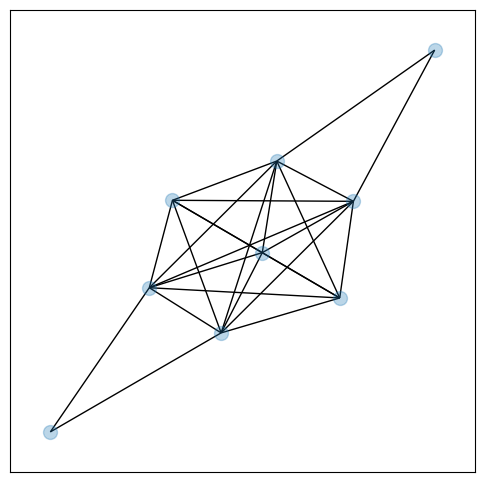

In [24]:
g = nx.Graph()
g.add_edges_from(np.argwhere(drugs_graph[a:a+b,a:a+b]!=0))
plot_graph(g, node_size=100)

## Create a graph in which nodes represent genes and edges represent  

In [231]:
genes = transpose(drugs)

In [232]:
genes_graph = build_graph_from_dict( genes )

  0%|          | 0/1244 [00:00<?, ?it/s]

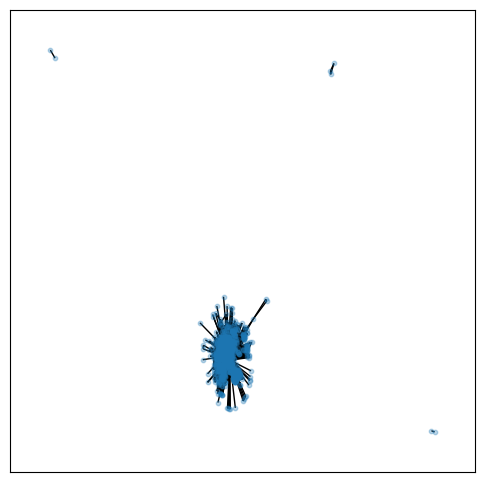

In [233]:
g=nx.Graph()
g.add_edges_from(np.argwhere(genes_graph!=0))
plot_graph(g)

In [321]:
genes_graph

array([[0., 8., 0., ..., 0., 0., 0.],
       [8., 0., 7., ..., 0., 0., 0.],
       [0., 7., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Big Clam

- Hold out set the **Edges** 20%, verificar se o grafo é totalmente reconstruído
- comparar softmax e mse
- 

In [16]:
(drugs_graph==0).sum()/np.prod(drugs_graph.shape)

0.588159059429913

In [25]:
NN = drugs_graph.shape[0]

In [26]:
ϵ = len(np.argwhere(drugs_graph!=0)) / (1101 * 1100)

In [27]:
δ = np.sqrt(-np.log(1 - ϵ))
δ

0.7289681920869288

In [28]:
conns = {i : np.where(node_conns!=0)[0] for i, node_conns in enumerate(drugs_graph)}
nconns = {i : np.where(node_conns==0)[0] for i, node_conns in enumerate(drugs_graph)}

In [41]:
k=10
#F = np.apply_along_axis(softmax, 1, np.random.normal(size=( genes_graph.shape[0], k ) ))

#F = np.random.uniform(size=( bigraph.shape[0], k ))
MAX = 1
F = get_F((NN, k), max_=MAX)
F = local_neigh_F((NN, K), conns)
res=np.array([-log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(F.shape[0])]).sum()
print("Initial Evaluation: ", res)

Initial Evaluation:  7328386.082650442


In [42]:
#F, LL =SHC(conns, nconns, F, niters=10000, LR=0.005)

#print("Final Evaluation: ", LL)
F, ll_ = big_clam(conns, nconns, F, n_iters=5000, LR=0.01, MAX_FVALUE=1)
print("Final Evaluation: ", ll_)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

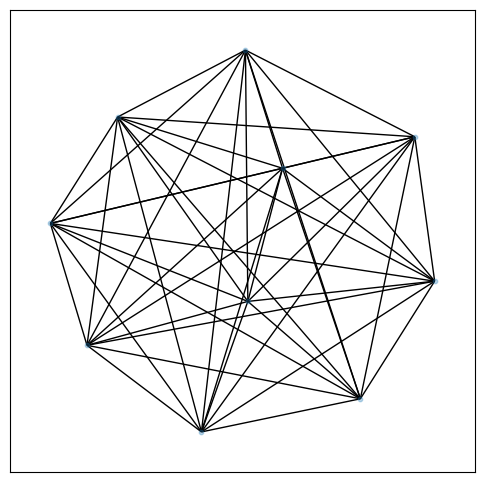

In [40]:
temp = get_graph_from_communities(F)
g = nx.Graph()
g.add_edges_from(np.argwhere(temp[a:a+b,a:a+b]!=0))
plot_graph(g, )

In [59]:
from sklearn.metrics import mean_squared_error, precision_score, recall_score

In [66]:
mean_squared_error( 
    (drugs_graph>=1) * 1, 
    (temp>0.5)*1, squared=False)

0.34899984246874716

In [64]:
mean_squared_error( 
    (drugs_graph[drugs_graph!=0]>=1)*1, 
    (temp[drugs_graph!=0]>0.5)*1, squared=False)

0.3301802797476701

In [67]:
precision_score(
    (drugs_graph[drugs_graph!=0]>=1)*1, 
    (temp[drugs_graph!=0]>0.5)*1
)

1.0

In [68]:
recall_score(
    (drugs_graph[drugs_graph!=0]>=1)*1,
    (temp[drugs_graph!=0]>0.5)*1
)

0.8909809828657503